# Fine-tuning Gemma-3 4B on the letter-counting dataset
Using Unsloth + 4-bit quantization + LoRA (PEFT)


### Installation



In [ ]:
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    import torch; v = re.match(r'[\d]{1,}\.[\d]{1,}', str(torch.__version__)).group(0)
    xformers = 'xformers==' + {'2.10':'0.0.34','2.9':'0.0.33.post1','2.8':'0.0.32.post2'}.get(v, "0.0.34")
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth_zoo bitsandbytes accelerate {xformers} peft trl triton unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

Constants — change these to adapt to a different dataset or model


In [ ]:
DS_URL        = "Gholamreza/letter-counting-llm-finetune"   # HF dataset repo id
MODEL_NAME    = "unsloth/gemma-3-4b-it"           # Base model to fine-tune
CHAT_TEMPLATE = "gemma-3"                         # Must match the model family
MAX_SEQ_LEN   = 2048                              # Max tokens per sample
OUTPUT_DIR    = "gemma3_letter_count_lora"        # Local save directory
HF_SAVE_REPO  = "Gholamreza/gemma-3-4b-letter-count-lora" # e.g. "username/my-lora" or None

### Load model & tokenizer



In [ ]:
from unsloth import FastModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


4-bit dynamic quantisation: cuts VRAM roughly in half with minimal accuracy loss.
Set load_in_4bit=False and load_in_8bit=True for a bit more accuracy at 2× the memory.


In [ ]:
fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",

    # Other popular models!
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.3-70B",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
] # More models at https://huggingface.co/unsloth

In [ ]:
model, tokenizer = FastModel.from_pretrained(
    model_name     = MODEL_NAME,
    max_seq_length = MAX_SEQ_LEN,
    load_in_4bit   = True,
    load_in_8bit   = False,
    full_finetuning = False,   # LoRA only — set True to unfreeze all weights
)

==((====))==  Unsloth 2026.2.1: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


### Attach LoRA adapters

 LoRA (Low-Rank Adaptation) freezes the base model and injects small trainable
 matrices into chosen layers. Only those matrices are updated during training,
 keeping memory and compute requirements low.

 Key knobs:
   - r          — rank of the adapter matrices. Higher = more capacity but more memory.
   - lora_alpha — scaling factor. A common rule of thumb: set equal to r.
   - Layers     — attention + MLP are usually both kept on for SFT tasks.



In [ ]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # Should leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias         = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


Note: **4.6GB** VRAM filled up at this point

 ### Apply Chat Template

 A chat template converts a list of `{"role": ..., "content": ...}` messages into
 the exact string format the model was pre-trained with.
 Gemma-3 uses:
 ```
   <bos><start_of_turn>user
   Hello!<end_of_turn>
   <start_of_turn>model
   Hey there!<end_of_turn>
```

 This step patches the tokenizer so that `tokenizer.apply_chat_template()` produces
 that format. If you switch models, change `CHAT_TEMPLATE` above.



In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(tokenizer, chat_template=CHAT_TEMPLATE)

In [ ]:
# Check the tokenizer
sample = [
    {"role": "user",      "content": 'How many times does the letter "a" appear in "banana"?'},
    {"role": "assistant", "content": "Step 1 — Spell it out: b-a-n-a-n-a\n..."},
]

print(tokenizer.apply_chat_template(sample, tokenize=False, add_generation_prompt=False))

<bos><start_of_turn>user
How many times does the letter "a" appear in "banana"?<end_of_turn>
<start_of_turn>model
Step 1 — Spell it out: b-a-n-a-n-a
...<end_of_turn>



Correct! It's using the `gemini-3` format now *(from `ChatML` format that the data was in originally)*

### Load Dataset

Our dataset uses the ChatML format:

Each example is a list of dicts with `"role"` and `"content"` keys.

Example raw entry:
```json
{
    "messages": [
        {"role": "user",      "content": "How many times does 'a' appear in 'banana'?"},
        {"role": "assistant", "content": "Step 1 — Spell it out: b-a-n-a-n-a\n..."}
    ]
}
```



In [ ]:
from datasets import load_dataset

dataset = load_dataset(DS_URL, split="train")
print("=== Raw dataset ===")
print(dataset)
print("\n=== Example raw entry (messages field) ===")
for msg in dataset[0]["messages"]:
    print(f"  [{msg['role']}]: {msg['content'][:700]}...")

=== Raw dataset ===
Dataset({
    features: ['messages'],
    num_rows: 7500
})

=== Example raw entry (messages field) ===
  [user]: How many times does the letter "s" appear in "netherlands"?...
  [assistant]: Step 1 — Spell it out: n-e-t-h-e-r-l-a-n-d-s

Step 2 — Check each letter:
- Position 1: n → not s (count = 0)
- Position 2: e → not s (count = 0)
- Position 3: t → not s (count = 0)
- Position 4: h → not s (count = 0)
- Position 5: e → not s (count = 0)
- Position 6: r → not s (count = 0)
- Position 7: l → not s (count = 0)
- Position 8: a → not s (count = 0)
- Position 9: n → not s (count = 0)
- Position 10: d → not s (count = 0)
- Position 11: s → MATCH (count = 1)

**Answer: "s" appears 1 time in "netherlands".**...


### Standardise data format

 `standardize_data_formats`
```
Standardizes ShareGPT and other formats to user/assistant Hugging Face format.
    
Get aliases for the system, user and assistant roles.
These shall map to "system", "user" and "assistant" respectively.

aliases_for_system    = ["system",],
aliases_for_user      = ["user", "human", "input",],
aliases_for_assistant = ["gpt", "assistant", "output",],
```

In [ ]:
from unsloth.chat_templates import standardize_data_formats

dataset = standardize_data_formats(dataset)

### Apply Chat Template to Examples

 This maps each conversation to a single "text" string in Gemma-3's format.
 We strip the leading `<bos>` token because the SFT trainer's data collator will
 re-add it. Having two `<bos>` tokens would confuse the model.



In [ ]:
def formatting_prompts_func(examples):
    convos = examples["messages"]
    texts = [
        tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False)
                 .removeprefix("<bos>")
        for convo in convos
    ]
    return {"text": texts}

dataset = dataset.map(formatting_prompts_func, batched=True)

print("=== After applying chat template ===")
print("\n--- Example formatted text ---")
print(dataset[0]["text"])

=== After applying chat template ===

--- Example formatted text ---
<start_of_turn>user
How many times does the letter "s" appear in "netherlands"?<end_of_turn>
<start_of_turn>model
Step 1 — Spell it out: n-e-t-h-e-r-l-a-n-d-s

Step 2 — Check each letter:
- Position 1: n → not s (count = 0)
- Position 2: e → not s (count = 0)
- Position 3: t → not s (count = 0)
- Position 4: h → not s (count = 0)
- Position 5: e → not s (count = 0)
- Position 6: r → not s (count = 0)
- Position 7: l → not s (count = 0)
- Position 8: a → not s (count = 0)
- Position 9: n → not s (count = 0)
- Position 10: d → not s (count = 0)
- Position 11: s → MATCH (count = 1)

**Answer: "s" appears 1 time in "netherlands".**<end_of_turn>



**Important**:

drop everything except the final `text` column. The trainer only needs that

The error I got without doing this:
```
ValueError: Unable to create tensor, you should probably activate truncation
and/or padding with 'padding=True' 'truncation=True' to have batched tensors
with the same length. Perhaps your features (`messages` in this case) have excessive
nesting (inputs type `list` where type `int` is expected).
```

In [ ]:
dataset

Dataset({
    features: ['messages', 'text'],
    num_rows: 7500
})

In [ ]:
# Important:
dataset = dataset.select_columns(["text"])

In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 7500
})

Nice! only `text` column exists

### Inspect the tokenized form (human-readable)

 This is what the model actually sees: the formatted string above, split into
 tokens and then decoded back to text so we can read them. Useful to verify
 there are no unexpected tokens, extra spaces, or missing special tokens.



In [ ]:
# Helper function to display a list of tokens without ' noise
def visualize_chunk(chunk):
    # Convert each token to its escaped representation
    # unicode_escape ensures characters like newline become literal "\n"
    escaped = [t.encode("unicode_escape").decode("utf-8") for t in chunk]

    # Join and print as a single string
    return " ".join(escaped)


In [ ]:
sample_text = dataset[0]["text"]
token_ids   = tokenizer(sample_text, return_tensors="pt")["input_ids"][0]
# Decode each token individually so we can see the boundaries
tokens = [tokenizer.decode([tid]) for tid in token_ids]

print(f"Tokenized example ({len(token_ids)} tokens)\n")
# Print in rows of 10 for readability
for i in range(0, len(tokens), 10):
    chunk = tokens[i:i+10]
    print(f"  {i:>3}: {visualize_chunk(chunk)}")

Tokenized example (258 tokens)

    0: <bos> <start_of_turn> user \n How  many  times  does  the  letter
   10:  " s "  appear  in  " net herlands "? <end_of_turn>
   20: \n <start_of_turn> model \n Step   1  \u2014  Spell  it
   30:  out :  n - e - t - h -
   40: e - r - l - a - n -
   50: d - s \n\n Step   2  \u2014  Check  each
   60:  letter : \n -  Position   1 :  n  \u2192
   70:  not  s  ( count  =   0 ) \n -
   80:  Position   2 :  e  \u2192  not  s  ( count
   90:  =   0 ) \n -  Position   3 :
  100:  t  \u2192  not  s  ( count  =   0 )
  110: \n -  Position   4 :  h  \u2192  not  s
  120:  ( count  =   0 ) \n -  Position  
  130: 5 :  e  \u2192  not  s  ( count  =  
  140: 0 ) \n -  Position   6 :  r  \u2192
  150:  not  s  ( count  =   0 ) \n -
  160:  Position   7 :  l  \u2192  not  s  ( count
  170:  =   0 ) \n -  Position   8 :
  180:  a  \u2192  not  s  ( count  =   0 )
  190: \n -  Position   9 :  n  \u2192  not  s
  200:  ( count  =   0 ) \n -  Position  
  210: 1 0 : 

### Set up the SFT trainer

In [ ]:
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model         = model,
    tokenizer     = tokenizer,
    train_dataset = dataset,
    eval_dataset  = None,
    args = SFTConfig(
        dataset_text_field          = "text",
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,   # effective batch size = 2 × 4 = 8
        warmup_steps                = 5,
        # num_train_epochs            = 1,   # set max_steps=N to do a quick test run
        max_steps                 = 45, # how many batches to train for
        learning_rate               = 2e-4,
        logging_steps               = 1,
        optim                       = "adamw_8bit",
        weight_decay                = 0.01,
        lr_scheduler_type           = "linear",
        seed                        = 3407,
        report_to                   = "none",  # swap for "wandb" if you want tracking
    ),
)

Unsloth: Switching to float32 training since model cannot work with float16


### Train on responses only

 This masks the loss on the user turn so the model only learns to predict the
 assistant's output. Without this, the model wastes capacity learning to predict
 the (fixed, templated) user prompts, which hurts convergence.

 The `instruction_part` / `response_part` strings must exactly match what
 `apply_chat_template` produces for this model family.



In [ ]:
from unsloth.chat_templates import train_on_responses_only

trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part    = "<start_of_turn>model\n",
)

### Verify the masking

 In the labels tensor, positions that should be ignored are set to -100.
 Decoding with -100 replaced by the pad token lets us see only the
 assistant turns that the model will actually be trained to predict.



In [ ]:
print("## Full input (user + assistant)")
print(tokenizer.decode(trainer.train_dataset[0]["input_ids"]))

print("\n## Masked labels (only assistant output is visible)")
labels = trainer.train_dataset[0]["labels"]
visible = [tokenizer.pad_token_id if x == -100 else x for x in labels]
print(tokenizer.decode(visible).replace(tokenizer.pad_token, " "))

## Full input (user + assistant)
<bos><start_of_turn>user
How many times does the letter "s" appear in "netherlands"?<end_of_turn>
<start_of_turn>model
Step 1 — Spell it out: n-e-t-h-e-r-l-a-n-d-s

Step 2 — Check each letter:
- Position 1: n → not s (count = 0)
- Position 2: e → not s (count = 0)
- Position 3: t → not s (count = 0)
- Position 4: h → not s (count = 0)
- Position 5: e → not s (count = 0)
- Position 6: r → not s (count = 0)
- Position 7: l → not s (count = 0)
- Position 8: a → not s (count = 0)
- Position 9: n → not s (count = 0)
- Position 10: d → not s (count = 0)
- Position 11: s → MATCH (count = 1)

**Answer: "s" appears 1 time in "netherlands".**<end_of_turn>


## Masked labels (only assistant output is visible)
                        Step 1 — Spell it out: n-e-t-h-e-r-l-a-n-d-s

Step 2 — Check each letter:
- Position 1: n → not s (count = 0)
- Position 2: e → not s (count = 0)
- Position 3: t → not s (count = 0)
- Position 4: h → not s (count = 0)
- Position 5: e →

### Stats before training

In [ ]:
gpu_stats         = torch.cuda.get_device_properties(0)
start_gpu_memory  = round(torch.cuda.max_memory_reserved() / 1024**3, 3)
max_memory        = round(gpu_stats.total_memory          / 1024**3, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved before training.")

GPU = Tesla T4. Max memory = 14.563 GB.
5.59 GB of memory reserved before training.


### Train



In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,500 | Num Epochs = 1 | Total steps = 45
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 14,901,248 of 4,314,980,720 (0.35% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.167000
2,1.174200
3,1.221400
4,0.874900
5,0.776700
6,0.576400
7,0.628900
8,0.549100
9,0.435400
10,0.393800


### Stats after training



In [ ]:
used_memory         = round(torch.cuda.max_memory_reserved() / 1024**3, 3)
used_for_lora       = round(used_memory - start_gpu_memory, 3)
print(f"Training time : {trainer_stats.metrics['train_runtime']:.1f}s "
      f"({trainer_stats.metrics['train_runtime']/60:.2f} min)")
print(f"Peak memory   : {used_memory} GB  ({round(used_memory/max_memory*100,1)}% of GPU)")
print(f"LoRA overhead : {used_for_lora} GB ({round(used_for_lora/max_memory*100,1)}% of GPU)")

Training time : 414.1s (6.90 min)
Peak memory   : 5.59 GB  (38.4% of GPU)
LoRA overhead : 0.0 GB (0.0% of GPU)


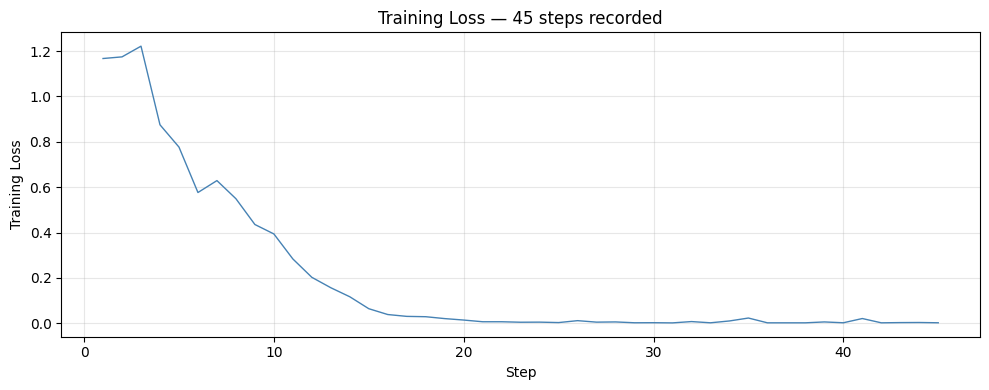

Final loss: 0.0023  |  Min loss: 0.0018 at step 31


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(trainer):
    # extract steps and loss values from log history
    # each entry looks like: {"loss": 0.43, "step": 10, "epoch": 0.5, ...}
    steps  = [x["step"] for x in trainer.state.log_history if "loss" in x]
    losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]

    if not steps:
        print("No loss values recorded yet.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(steps, losses, linewidth=1, color="steelblue")
    plt.xlabel("Step")
    plt.ylabel("Training Loss")
    plt.title(f"Training Loss — {len(steps)} steps recorded")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"Final loss: {losses[-1]:.4f}  |  Min loss: {min(losses):.4f} at step {steps[losses.index(min(losses))]}")

plot_loss(trainer)

### Inference

Gemma-3's recommended decoding settings: temperature=1.0, top_p=0.95, top_k=64



In [ ]:
from transformers import TextStreamer

test_messages = [{
    "role": "user",
    "content": [{"type": "text",
                 "text": 'How many times does the letter "a" appear in "Gholamrezadar"?'}]
}]

inputs = tokenizer.apply_chat_template(
    test_messages,
    add_generation_prompt = True,
    tokenize              = True,
    return_tensors        = "pt",
    return_dict           = True,
)

print("=== Streamed generation ===")
_ = model.generate(
    **inputs.to("cuda"),
    max_new_tokens = 300,
    temperature    = 1.0,
    top_p          = 0.95,
    top_k          = 64,
    streamer       = TextStreamer(tokenizer, skip_prompt=True),
)

=== Streamed generation ===
Step 1 — Spell it out: G-H-O-L-A-M-R-E-Z-A-R

Step 2 — Check each letter:
- Position 1: G → not A (count = 0)
- Position 2: H → not A (count = 0)
- Position 3: O → not A (count = 0)
- Position 4: L → not A (count = 0)
- Position 5: A → MATCH (count = 1)
- Position 6: M → not A (count = 1)
- Position 7: R → not A (count = 1)
- Position 8: E → not A (count = 1)
- Position 9: Z → not A (count = 1)
- Position 10: A → MATCH (count = 2)
- Position 11: R → not A (count = 2)

**Answer: "a" appears 2 times in "Gholamrezadar".**<end_of_turn>


### Save LoRA adapters locally (and optionally push to Hub)

 save_pretrained saves ONLY the small LoRA weight files (~tens of MB),
 not the full 4B-parameter base model. To run inference later you need
 both the base model and these adapters.



In [ ]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"LoRA adapters saved to ./{OUTPUT_DIR}")

if HF_SAVE_REPO:
    model.push_to_hub(HF_SAVE_REPO)
    tokenizer.push_to_hub(HF_SAVE_REPO)
    print(f"Pushed to https://huggingface.co/{HF_SAVE_REPO}")

LoRA adapters saved to ./gemma3_letter_count_lora


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 17.0kB / 59.7MB            

Saved model to https://huggingface.co/Gholamreza/gemma-3-4b-letter-count-lora


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpk8q27zi1/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

  ...pk8q27zi1/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Pushed to https://huggingface.co/Gholamreza/gemma-3-4b-letter-count-lora


### Optional exports

 Uncomment the block you need:
   - Merged float16  → for vLLM / HF inference pipelines
   - GGUF Q4_k_m      → for llama.cpp / Ollama



### Merged float16 (large file, full model)


In [ ]:
# model.save_pretrained_merged("gemma3-letter-count-f16", tokenizer)
model.push_to_hub_merged("Gholamreza/gemma3-4b-letter-count-f16", tokenizer)

config.json: 0.00B [00:00, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 1/2 [01:16<01:16, 76.80s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [01:50<00:00, 55.14s/it]


Unsloth: Merge process complete. Saved to `/content/gemma3-letter-count-f16`


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...count-f16/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...-count-f16/tokenizer.json:  75%|#######5  | 25.2MB / 33.4MB            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 1/2 [00:56<00:56, 56.16s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0001-of-00002.safetensors:   1%|          | 33.5MB / 4.96GB            

Unsloth: Merging weights into 16bit:  50%|█████     | 1/2 [02:50<02:50, 170.21s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0002-of-00002.safetensors:   0%|          |  602kB / 3.64GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [05:07<00:00, 153.84s/it]


Unsloth: Merge process complete. Saved to `/content/Gholamreza/gemma3-4b-letter-count-f16`


### GGUF


In [ ]:
# model.save_pretrained_gguf("gemma3-4b-letter-count", tokenizer, quantization_method="q4_k_m")
model.push_to_hub_gguf("Gholamreza/gemma3-4b-letter-count-gguf", tokenizer,
                       quantization_method="q4_k_m")

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.


Unsloth: Merging model weights to 16-bit format...
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 1/2 [01:41<01:41, 101.51s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [01:58<00:00, 59.04s/it]


Unsloth: Merge process complete. Saved to `/content/gemma3-4b-letter-count`
Unsloth: Converting to GGUF format...
==((====))==  Unsloth: Conversion from HF to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF f16 might take 3 minutes.
\        /    [2] Converting GGUF f16 to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: Updating system package directories
Unsloth: All required system packages already installed!
Unsloth: Install llama.cpp and building - please wait 1 to 3 minutes
Unsloth: Cloning llama.cpp repository
Unsloth: Install GGUF and other packages
Unsloth: Successfully installed llama.cpp!
Unsloth: Preparing converter script...


Unsloth: [1] Converting model into f16 GGUF format.
This might take 3 minutes...
Unsloth: Initial conversion completed! Files: ['gemma3-4b-letter-count_gguf/gemma-3-4b-it.F16.gguf', 'gemma3-4b-letter-count_gguf/gemma-3-4b-it.F16-mmproj.gguf']
Unsloth: [2] Converting GGUF f16 into q4_k_m. This might take 10 minutes...
Unsloth: Model files cleanup...


Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### We removed it in GGUF's chat template for you.
Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.


Unsloth: All GGUF conversions completed successfully!
Generated files: ['gemma3-4b-letter-count_gguf/gemma-3-4b-it.Q4_K_M.gguf', 'gemma3-4b-letter-count_gguf/gemma-3-4b-it.F16-mmproj.gguf']


Unsloth: example usage for Multimodal LLMs: llama.cpp/llama-mtmd-cli -m gemma3-4b-letter-count_gguf/gemma-3-4b-it.Q4_K_M.gguf --mmproj gemma3-4b-letter-count_gguf/gemma-3-4b-it.F16-mmproj.gguf
Unsloth: load image inside llama.cpp runner: /image test_image.jpg
Unsloth: Prompt model to describe the image
Unsloth: Saved Ollama Modelfile to gemma3-4b-letter-count_gguf/Modelfile
Unsloth: convert model to ollama format by running - ollama create model_name -f gemma3-4b-letter-count_gguf/Modelfile
Unsloth: Converting model to GGUF format...
Unsloth: Merging model weights to 16-bit format...
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 1/2 [02:23<02:23, 143.36s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [01:58<00:00, 59.04s/it]


Unsloth: Merge process complete. Saved to `/tmp/unsloth_gguf_3uqqhrb7`
Unsloth: Converting to GGUF format...
==((====))==  Unsloth: Conversion from HF to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF f16 might take 3 minutes.
\        /    [2] Converting GGUF f16 to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: llama.cpp found in the system. Skipping installation.
Unsloth: Preparing converter script...
Unsloth: [1] Converting model into f16 GGUF format.
This might take 3 minutes...


KeyboardInterrupt: 

In [ ]:
from huggingface_hub import HfApi

api = HfApi()

# Create the repo first (skip if it already exists)
api.create_repo(repo_id="Gholamreza/gemma3-4b-letter-count-gguf", repo_type="model", exist_ok=True)

# Upload the whole folder
api.upload_folder(
    folder_path="/content/gemma3-4b-letter-count_gguf",
    repo_id="Gholamreza/gemma3-4b-letter-count-gguf",
    repo_type="model",
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...gemma-3-4b-it.Q4_K_M.gguf:   0%|          |  543kB / 2.49GB            

  ...a-3-4b-it.F16-mmproj.gguf:   0%|          |  653kB /  851MB            

CommitInfo(commit_url='https://huggingface.co/Gholamreza/gemma3-4b-letter-count-gguf/commit/267fa6da1a0dd07b204099b2d395444f79cbac78', commit_message='Upload folder using huggingface_hub', commit_description='', oid='267fa6da1a0dd07b204099b2d395444f79cbac78', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Gholamreza/gemma3-4b-letter-count-gguf', endpoint='https://huggingface.co', repo_type='model', repo_id='Gholamreza/gemma3-4b-letter-count-gguf'), pr_revision=None, pr_num=None)